In [1]:
%matplotlib inline
import numpy as np
import glob
import os.path as path
import pickle
import re
import gc

from scipy.io import wavfile
from scipy.interpolate import interp1d

from listen.spectrogram.spectrogram import Spectrogram
from listen.utils.filters import Filter

"""
Utility functions
"""

def db_to_float(db):
    return 10 ** (db / 20)

def chunk_it(xs, chunk_size):
    for i in range(0, len(xs), chunk_size):
        yield xs[i:i + chunk_size]

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "{:3.1f}{}{}".format(num, unit, suffix)
        num /= 1024.0
    return "{:.1f}{}{}".format(num, 'Yi', suffix)

"""
Constants.
"""

DATA_DIR = path.realpath('./listen/data/gen/proc')
DATASET_PATH = './listen/data/gen/pickled/'
DATASET_PATH_FMT = DATASET_PATH + 'data_batch_{}.pkl'
MAX_NB_COPIES = 12

# 1% of the dataset is silence
SILENCE_RELATIVE_COUNT = 0.01
SILENCE_RANGE_DB = (-60, -40)

# Sample rate
RATE = 22050

# Speech duration in seconds for pitch-invariant scaling
SPEECH_DURATION = 0.7


FFT_SIZE = 2048
STEP_SIZE = FFT_SIZE // 8
LOG_THRESHOLD = 6
CHUNK_SIZE = 1000
NB_MFCC_BINS = 54
FREQ_RANGE = (0, 8000)
"""
Generating the dataset.
"""

# Get all the wav files
wavs = list(glob.iglob(path.join(DATA_DIR, '**/*.wav'), recursive=True))

# Print total size being read
print("Reading: {}...".format(sizeof_fmt(sum(path.getsize(w) for w in wavs))))

utterances = list(set(map(lambda w: re.match(r'[a-z]+', path.basename(w)).group(0), wavs)))

# Dump the labels
data_file = open(path.realpath(DATASET_PATH + 'all_labels.pkl'), "wb")
pickle.dump({'label_names': ['_'] + utterances}, data_file, pickle.HIGHEST_PROTOCOL)
data_file.close()
print('Wrote labels to file.')

glob_max = -1

# Shuffle input files
np.random.shuffle(wavs)

# spec = Spectrogram(FFT_SIZE, STEP_SIZE, LOG_THRESHOLD)

# for chunk_idx, chunk in enumerate(chunk_it(wavs, CHUNK_SIZE)):
#     print("Processing chunk {}, size={}".format(chunk_idx, sizeof_fmt(sum(path.getsize(c) for c in chunk))))
#     cepstra = []
#     utterance_idx = []
#     dump_data = {}
    
#     for wav in chunk:
#         rate, snd = wavfile.read(wav, mmap=True)
#         m = np.max(snd)
#         glob_max = max(m, glob_max)
#         # Split file name to extract utterance
#         utterance = re.match(r'[a-z]+', path.basename(wav)).group(0)
#         uidx = utterances.index(utterance)
#         # Poor man's data variance
#         noise_db = np.random.uniform(*SILENCE_RANGE_DB)
#         noise_level = m * db_to_float(noise_db)
#         nb_copies = np.random.randint(1, MAX_NB_COPIES)
#         for i in range(nb_copies):
#             noise = np.random.normal(0, noise_level, len(snd))
#             factor = SPEECH_DURATION * rate / len(snd)
#             sound = Filter.time_stretch(snd + noise, factor)
#             sound = sound / np.max(sound)
#             cep = spec.compute_mel_cepstrum(sound.astype('float32'), nb_mfcc_bins=NB_MFCC_BINS, frange=FREQ_RANGE)
#             # Ensure square shape with piecewise linear interpolation
#             if cep.shape[0] != cep.shape[1]:
#                 interpolant = interp1d(np.linspace(0, 1, cep.shape[1]), cep, axis=1, fill_value='extrapolate')
#                 cep = interpolant(np.linspace(0, 1, cep.shape[0]))
#             cepstra.append(cep - np.mean(cep))
#             # Reserve index 0 for use later
#             utterance_idx.append(uidx + 1)        
#     """
#     Add silence as data
#     """
#     # Manually add noise as silence now
#     nb_silent = int(SILENCE_RELATIVE_COUNT * len(cepstra))
#     for i in range(nb_silent):
#         noise_db = np.random.uniform(*SILENCE_RANGE_DB)
#         noise_level = (10 ** (noise_db / 20)) * glob_max
#         noise = np.random.normal(0, noise_level, len(snd))
#         cep = spec.compute_mel_cepstrum(noise.astype('float32'), nb_mfcc_bins=NB_MFCC_BINS, frange=FREQ_RANGE)
#         if cep.shape[0] != cep.shape[1]:
#             interpolant = interp1d(np.linspace(0, 1, cep.shape[1]), cep, axis=1, fill_value='extrapolate')
#             cep = interpolant(np.linspace(0, 1, cep.shape[0]))
#         cepstra.append(cep)
#         # Silence is index 0
#         utterance_idx.append(0)

#     # Shuffle again to avoid keeping copies together
#     nb_data = len(cepstra)
#     perm = np.random.permutation(nb_data)
#     cepstra = np.array(cepstra)
#     utterance_idx = np.array(utterance_idx)
#     # Shuffle axis 0
#     cepstra = cepstra[perm, :, :]
#     utterance_idx = utterance_idx[perm]
    
#     print(cepstra.shape, utterance_idx.shape)
    
#     # Just a sanity check assertion
#     assert(cepstra.shape[0] == utterance_idx.shape[0]), "Data, Label vectors shapes do not match!"

#     print("Working with {0} ({1} unique) sounds, including silence. )".format(nb_data, len(chunk)))

#     """
#     Serializing the dataset.
#     """
#     # Split into training and validation sets (10% for validation, 90% for training)
#     dump_data = {
#         'validation_x': cepstra[nb_data//10:],
#         'validation_y': utterance_idx[nb_data//10:], 
#         'training_x': cepstra[:nb_data//10],
#         'training_y': utterance_idx[:nb_data//10]
#     }
    
#     # Dump dataset
#     data_file = open(DATASET_PATH_FMT.format(chunk_idx), "wb")
#     pickle.dump(dump_data, data_file, pickle.HIGHEST_PROTOCOL)
#     data_file.close()
#     # Trigger GC to clear all the massive number of references we now have remaining 
#     gc.collect()

# print("Done.")

Reading: 250.7MiB...
Wrote labels to file.


(54, 54)
(40, 40)
(40, 40)


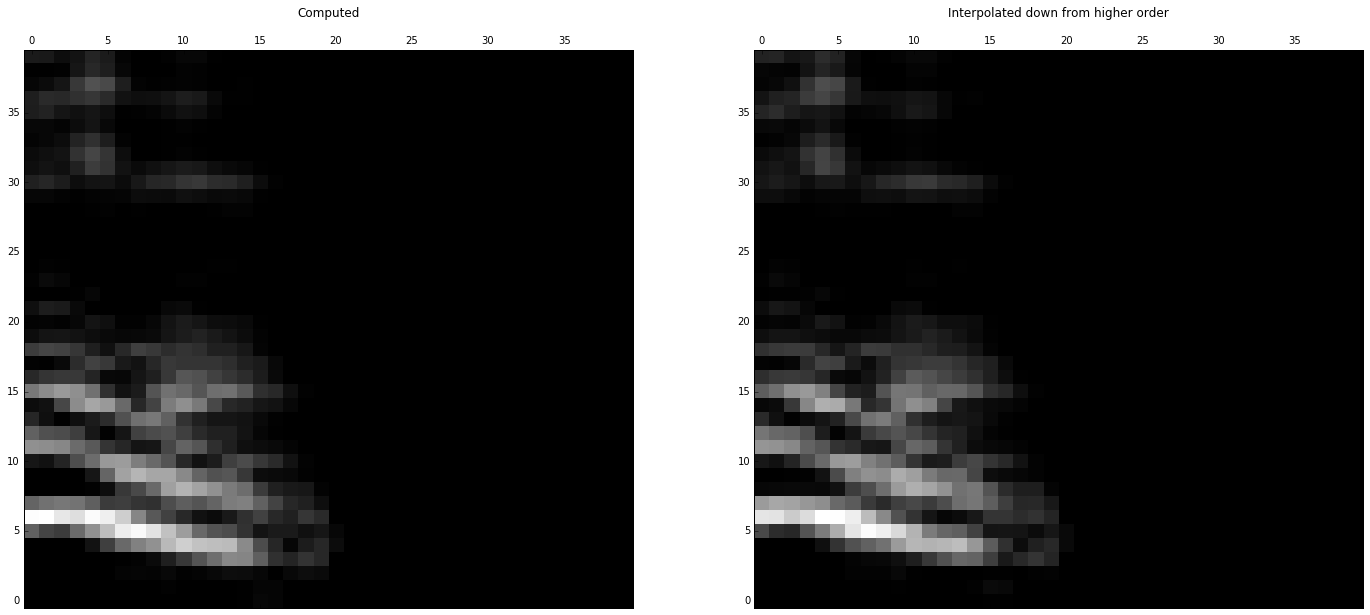

In [86]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display

from scipy.interpolate import interp1d

from listen.utils.filters import Filter

FFT_SIZE = 2048
STEP_SIZE = FFT_SIZE // 8
LOG_THRESHOLD = 5

spec = Spectrogram(FFT_SIZE, STEP_SIZE, LOG_THRESHOLD)
name = wavs[np.random.randint(0, len(wavs))]
rate, data = wavfile.read(name)
factor = 0.7 * rate / len(data)
# data =  data.astype(np.float32) + np.random.normal(0, (1e-2) * np.max(data), len(data))
data_stretched = Filter.time_stretch(data, factor)
data_stretched = data_stretched / np.max(data_stretched)
mel_cepstrum = spec.compute_mel_cepstrum(data_stretched.astype('float32'), nb_mfcc_bins=54, frange=(0, 8000))
print(mel_cepstrum.shape)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(24,10))

mel_cepstrum2 = mel_cepstrum
mel_cepstrum2 = (interp1d(np.linspace(0, 1, mel_cepstrum.shape[1]), mel_cepstrum, axis=1, kind='slinear'))(np.linspace(0, 1, 40))
mel_cepstrum2 = (interp1d(np.linspace(0, 1, mel_cepstrum2.shape[0]), mel_cepstrum2, axis=0, kind='slinear'))(np.linspace(0, 1, 40))

mel_cepstrum = spec.compute_mel_cepstrum(data_stretched.astype('float32'), nb_mfcc_bins=40, frange=(0, 8000))
if(mel_cepstrum.shape[0] != mel_cepstrum.shape[1]):
    mel_cepstrum = (interp1d(np.linspace(0, 1, mel_cepstrum.shape[1]), mel_cepstrum, axis=1))(np.linspace(0, 1, mel_cepstrum.shape[0]))

print(mel_cepstrum.shape)
print(mel_cepstrum2.shape)
ax[0].matshow(mel_cepstrum, interpolation='nearest', aspect='auto', cmap=plt.cm.gray, origin='lower')
ax[0].set_title('Computed')
ax[1].matshow(mel_cepstrum2, interpolation='nearest', aspect='auto', cmap=plt.cm.gray, origin='lower')
ax[1].set_title('Interpolated down from higher order')
plt.show()
IPython.display.Audio(data=(data_stretched), rate=rate)